In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import *
from scipy.signal import *
import datetime
from scipy import *
from shapely.geometry import *
import geopandas as gpd
import xarray as xr
import os
from datetime import *
import requests
import glob

In [3]:
#Location
lat_target = 41.639164
lon_target = -9.142327

lon_vals = np.linspace(-180, 180, 734)
lat_vals = np.linspace(-90, 90, 834)

# Find nearest index
lon_idx = (np.abs(lon_vals - lon_target)).argmin()
lat_idx = (np.abs(lat_vals - lat_target)).argmin()

print(f"longitude index = {lon_idx}, value = {lon_vals[lon_idx]}")
print(f"latitude index  = {lat_idx}, value = {lat_vals[lat_idx]}")

longitude index = 348, value = -9.085948158253757
latitude index  = 609, value = 41.596638655462186


In [4]:
inp_wave            = "OpenDAP"
solve_wave          = True

start_year          = 1991
end_year            = 2021

path_to_data_wave   = r'F:/TUDELFT/Thesis/Thesis_CODE/ECHOWAVE/'

In [5]:
def process_wave(lat_target, lon_target, path_to_data_wave=None):
    dfs = []
    
    for file in glob.glob(os.path.join(path_to_data_wave, "*.csv")):
        df_wave = pd.read_csv(file)

        df_wave['Time'] = pd.to_datetime(df_wave['Time'])
        df_wave.set_index('Time', inplace=True)

        df = pd.DataFrame()
        df['Hs'] = df_wave['Hs']
        df['Tp'] = df_wave['Tp']
        dfs.append(df)

    df_wave_all = pd.concat(dfs).sort_index()
    return df_wave_all

In [6]:
def run_config(solve_wave, inp_wave):
    starttime = time.time()
    
    if lon_target > -8.7 and lon_target < -9.5:
        if lat_target > 42 and lat_target < 41:
            pass
        else:
            print('     latitude not solved in ResourceCode domain, please use different input')
            return
    else:
        print('     latitude not solved in ResourceCode domain, please use different input')
        return
    if solve_wave == True and inp_wave == "RC":
        print("     Wave is selected, input data is taken from ResourceCode")
    if solve_wave == True and inp_wave == "OpenDAP":
        print("     Wave is selected, input data is taken from OpenDAP")
    elif solve_wave == True and inp_wave == "other":
        print("     Wave is selected, input data is from other input file, please make sure it is loaded and compatible")
    elif solve_wave == False:
        print("     Wave is not selected")
    else:
        print("     Configuration not recognized, please check input file")
        
    endtime = time.time()
    print('         ...elapsed time:', round(endtime - starttime,2), 'seconds')

In [7]:
def get_resources_raw(solve_wave, inp_wave, start, end, lat_target=None, lon_target=None, path=None, path_wave=None):
    print('Running: get_resources_raw...')

    df = pd.DataFrame()
    
    if solve_wave == True and inp_wave == 'RC':
        if lat_target == None or lon_target == None or lat_target == None and lon_target == None:
            print("ResourceCode is selected, but no lat an/or lon is given as input")
        else:
            df['Hs'] = get_data_resourcecode(lat_target, lon_target, start, end)[0]
            df['Tp'] = get_data_resourcecode(lat_target, lon_target, start, end)[1]
    elif solve_wave == True and inp_wave == "OpenDAP":
        if path_wave == None:
            print("No path to OpenDAP data defined")
        else:
            print("warning: OpenDAP column name is now hard coded, not sure if all input files have the same column name")
            df_wave = process_wave(lat_target, lon_target, path_wave)
            df['Hs'] = df_wave['Hs']
            df['Tp'] = df_wave['Tp']
    elif solve_wave == True and inp_wave == "other":
        print("You will need to adjust this function to load the data of the wave resources")
    elif solve_wave == False:
        pass

    return df

In [8]:
resources_raw = get_resources_raw(
    solve_wave, 
    inp_wave, 
    start_year, 
    end_year, 
    lat_target, 
    lon_target, 
    None, 
    path_wave=path_to_data_wave
)

resources_raw.index = pd.date_range(start=f"{start_year}", periods=len(resources_raw), freq="H")

Running: get_resources_raw...


In [9]:
resources_raw

,Hs,Tp
1991-01-01 00:00:00,4.526,16.109999
1991-01-01 01:00:00,4.452,16.060000
1991-01-01 02:00:00,4.376,15.990000
1991-01-01 03:00:00,4.296,15.910000
1991-01-01 04:00:00,4.210,15.679999
...,...,...
2021-12-31 19:00:00,3.112,12.860000
2021-12-31 20:00:00,3.118,11.920000
2021-12-31 21:00:00,3.144,12.349999
2021-12-31 22:00:00,3.194,12.090000


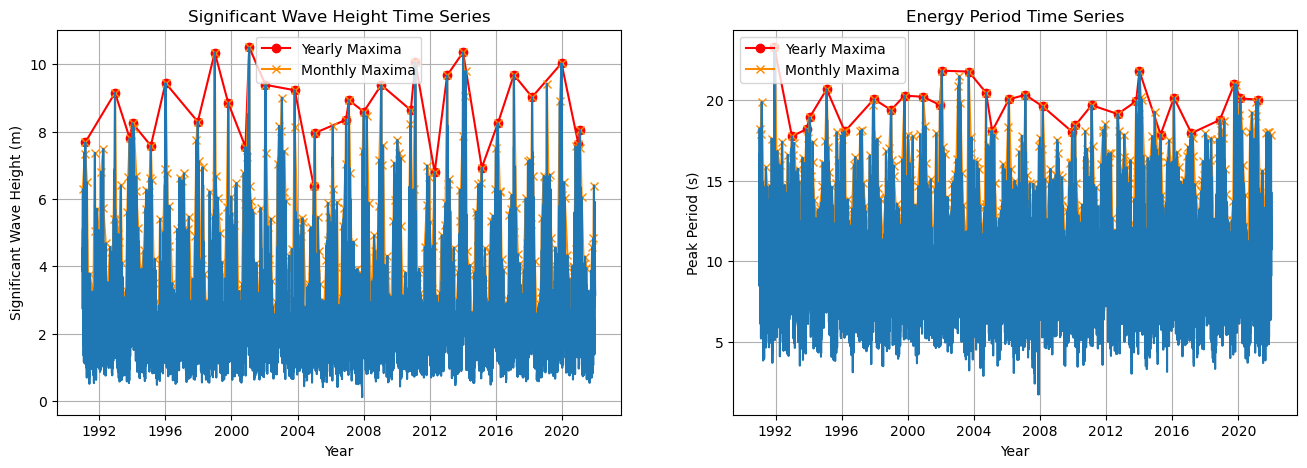

In [10]:
Hs_yearly_max_idx = resources_raw['Hs'].resample('Y').apply(lambda x: x.idxmax())
Hs_yearly_max = resources_raw['Hs'].resample('Y').max()

Hs_monthly_max_idx = resources_raw['Hs'].resample('M').apply(lambda x: x.idxmax())
Hs_monthly_max = resources_raw['Hs'].resample('M').max()

Te_yearly_max_idx = (resources_raw['Tp']*0.9).resample('Y').apply(lambda x: x.idxmax())
Te_yearly_max = (resources_raw['Tp']*0.9).resample('Y').max()

Te_monthly_max_idx = (resources_raw['Tp']*0.9).resample('M').apply(lambda x: x.idxmax())
Te_monthly_max = (resources_raw['Tp']*0.9).resample('M').max()
# Te = C * Tp, with C = 0.9 for JONSWAP spectrum standard (https://www.sciencedirect.com/science/article/abs/pii/S0029801821003723)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(Hs_yearly_max_idx, Hs_yearly_max, marker='o', linestyle='-', label='Yearly Maxima', color='red')
ax1.plot(Hs_monthly_max_idx, Hs_monthly_max, marker='x', linestyle='-', label='Monthly Maxima', color='darkorange')
ax1.plot(resources_raw.index, resources_raw['Hs'].values)
ax1.set_title('Significant Wave Height Time Series')
ax1.set_xlabel('Year')
ax1.set_ylabel('Significant Wave Height (m)')
ax1.grid(True)
ax1.legend()

ax2.plot(Te_yearly_max_idx, Te_yearly_max, marker='o', linestyle='-', label='Yearly Maxima', color='red')
ax2.plot(Te_monthly_max_idx, Te_monthly_max, marker='x', linestyle='-', label='Monthly Maxima', color='darkorange')
ax2.plot(resources_raw.index, (resources_raw['Tp']*0.9).values)
ax2.set_title('Energy Period Time Series')
ax2.set_xlabel('Year')
ax2.set_ylabel('Peak Period (s)')
ax2.grid(True)
ax2.legend()

Significant Wave Height Weibull parameters: shape=2.075, loc=0.000, scale=2.650
Peak Period Weibull parameters: shape=4.910, loc=0.000, scale=11.860


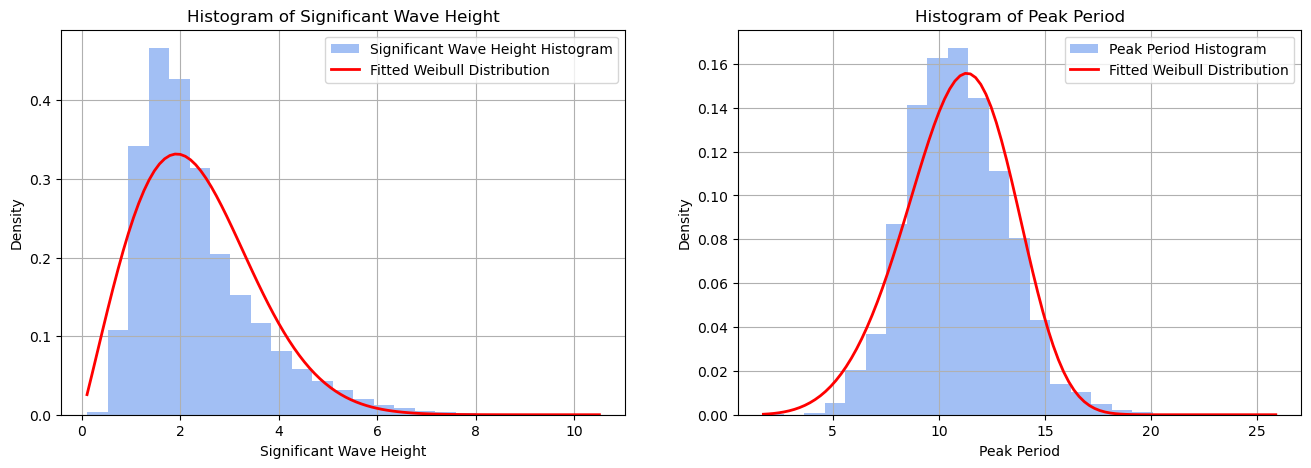

In [11]:
#Hs and Tp Histogram Plot 
Hs_data = resources_raw['Hs'].dropna()
Tp_data = resources_raw['Tp'].dropna()

params_weibull_Hs = weibull_min.fit(Hs_data, floc=0)
shape_weibull_Hs, loc_weibull_Hs, scale_weibull_Hs = params_weibull_Hs

params_weibull_Tp = weibull_min.fit(Tp_data, floc=0)
shape_weibull_Tp, loc_weibull_Tp, scale_weibull_Tp = params_weibull_Tp

x_Hs = np.linspace(Hs_data.min(), Hs_data.max(), 100)
x_Tp = np.linspace(Tp_data.min(), Tp_data.max(), 100)

pdf_weibull_Hs = weibull_min.pdf(x_Hs, shape_weibull_Hs, loc_weibull_Hs, scale_weibull_Hs)
pdf_weibull_Tp = weibull_min.pdf(x_Tp, shape_weibull_Tp, loc_weibull_Tp, scale_weibull_Tp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.hist(Hs_data, bins=25, density=True, alpha=0.6, color='cornflowerblue', label='Significant Wave Height Histogram')
ax1.set_title('Histogram of Significant Wave Height')
ax1.plot(x_Hs, pdf_weibull_Hs, 'r-', lw=2, label='Fitted Weibull Distribution')
ax1.set_xlabel('Significant Wave Height')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True)

ax2.hist(Tp_data, bins=25, density=True, alpha=0.6, color='cornflowerblue', label='Peak Period Histogram')
ax2.set_title('Histogram of Peak Period')
ax2.plot(x_Tp, pdf_weibull_Tp, 'r-', lw=2, label='Fitted Weibull Distribution')
ax2.set_xlabel('Peak Period')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True)

print(f'Significant Wave Height Weibull parameters: shape={shape_weibull_Hs:.3f}, loc={loc_weibull_Hs:.3f}, scale={scale_weibull_Hs:.3f}')
print(f'Peak Period Weibull parameters: shape={shape_weibull_Tp:.3f}, loc={loc_weibull_Tp:.3f}, scale={scale_weibull_Tp:.3f}')

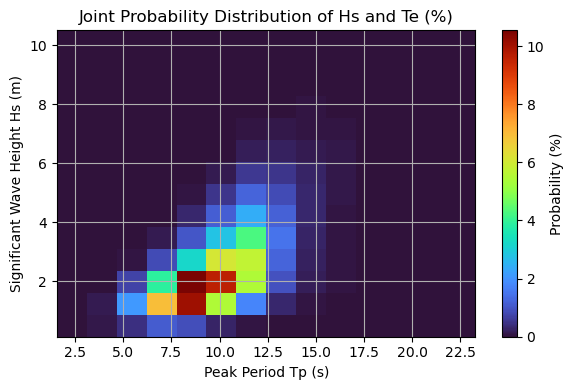

In [12]:
# Joint Probability Distribution using 2D Histogram
Hs = resources_raw['Hs'].dropna()
Tp = (resources_raw['Tp']*0.9).dropna()

# Ensure same length (drop unmatched NaNs)
data = pd.concat([Hs, Tp], axis=1).dropna()
Hs = data['Hs']
Tp = data['Tp']

# Define bins
hs_bins = np.linspace(Hs.min(), Hs.max(), 15)
tp_bins = np.linspace(Tp.min(), Tp.max(), 15)

# 2D histogram (joint occurrences)
hist, hs_edges, tp_edges = np.histogram2d(Hs, Tp, bins=[hs_bins, tp_bins], density=False)

# Convert to probability (%)
joint_prob = (hist / np.sum(hist)) * 100

# Plot
plt.figure(figsize=(6, 4))
pcm = plt.pcolormesh(tp_edges, hs_edges, joint_prob, cmap='turbo', shading='auto')
plt.xlabel('Peak Period Tp (s)')
plt.ylabel('Significant Wave Height Hs (m)')
plt.title('Joint Probability Distribution of Hs and Te (%)')
cbar = plt.colorbar(pcm, label='Probability (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# WEC Specification

In [13]:
def load_power_matrix(path):
    df_raw = pd.read_excel(path, header=None)
    tp_bins = pd.to_numeric(df_raw.iloc[4, 4:19].values, errors='coerce')
    hs_bins = pd.to_numeric(df_raw.iloc[6:15, 1].values, errors='coerce')
    power_values = df_raw.iloc[6:15, 4:19].values
    return pd.DataFrame(power_values, index=hs_bins, columns=tp_bins)

In [14]:
def compute_joint_probability_matrix(Hs, Tp, hs_bins, tp_bins):
    hist, hs_edges, tp_edges = np.histogram2d(Hs, Tp, bins=[hs_bins, tp_bins])
    joint_prob = hist / np.sum(hist)
    hs_centers = (hs_edges[:-1] + hs_edges[1:]) / 2
    tp_centers = (tp_edges[:-1] + tp_edges[1:]) / 2
    return pd.DataFrame(joint_prob, index=hs_centers, columns=tp_centers)

In [15]:
def compute_expected_power(power_matrix, prob_matrix):
    aligned = prob_matrix.reindex(index=power_matrix.index, columns=power_matrix.columns, method='nearest')
    return (power_matrix * aligned).sum().sum()

In [16]:
power_matrix_path = "F:/TUDELFT/Thesis/Thesis_CODE/Corpower.xlsx"
power_matrix = load_power_matrix(power_matrix_path)

np.random.seed(0)
Hs = resources_raw['Hs']
Tp = resources_raw['Tp'] * 0.9  #Te = 0.9Tp
data = pd.DataFrame({'Hs': Hs, 'Tp': Tp}).dropna()
Hs = data['Hs']
Tp = data['Tp']

In [17]:
#Determine binsbased on the PM
hs_bins = np.append(power_matrix.index.values, power_matrix.index.values[-1] + 0.5)
tp_bins = np.append(power_matrix.columns.values, power_matrix.columns.values[-1] + 1)

# Compute joint probability matrix
joint_prob_matrix = compute_joint_probability_matrix(Hs, Tp, hs_bins, tp_bins)

In [18]:
expected_power_kw = compute_expected_power(power_matrix, joint_prob_matrix)
print(f"Expected power output per device: {expected_power_kw:.2f} kW")

Expected power output per device: 241.96 kW


In [19]:
Nwecs = 450
r_power = 400 #kW

AEP_MWh = expected_power_kw * 8760 / 1000
print(f"Annual Energy Production per device: {AEP_MWh:.2f} MWh")

r_AEP = r_power * 8760 / 1000
print(f"Annual Energy Production per device in rated power: {r_AEP:.2f} MWh")

PEO = Nwecs * AEP_MWh
print(f"Total Wave Energy Park Output: {PEO:.2f} MWh/year")

CF = AEP_MWh / r_AEP 
CF_park = PEO / (r_AEP * Nwecs)
print(f"Capacity Factor: {CF:.2f}")
print(f"Park Capacity Factor: {CF_park:.2f}")

Annual Energy Production per device: 2119.53 MWh
Annual Energy Production per device in rated power: 3504.00 MWh
Total Wave Energy Park Output: 953787.30 MWh/year
Capacity Factor: 0.60
Park Capacity Factor: 0.60
